# Settings
---
This cell is to be run prior to all others. It sets parameters for data loading, plotting and saving.
All other cells are structured to be authonomously run.

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as  plt 
from matplotlib import colormaps 
from matplotlib import colors
from scipy.optimize import curve_fit  
import importlib

import ExperimParams as ee
importlib.reload(ee)

# parameters for figures saving
rcParamsDict_largeFont = {'font.size': 16,'lines.linewidth':3,'lines.markersize': 6,'figure.autolayout': False}
rcParamsDict_smallFont = {'font.size': 10,'lines.linewidth':2,'lines.markersize': 4,'figure.autolayout': False}
# choose parameters
plt.rcParams.update(rcParamsDict_largeFont)

#--------------------------------------------------------
def readTable1(dirIn="SPARCdata"):
    """
    Read data in "table1.dat" file in the dirIn folder, returns a list of dictionaries (named table).
    Each dict item is a row of the table, as in the description below. Dict keys correspond to labels in the table.

    ================================================================================
    Byte-by-byte Description of file: Table1.mrt
    --------------------------------------------------------------------------------
    Bytes Format Units         Label   Explanations
    --------------------------------------------------------------------------------
    1- 11 A11    ---           Galaxy  Galaxy Name
    12- 13 I2     ---           T       Hubble Type (1)
    14- 19 F6.2   Mpc           D       Distance
    20- 24 F5.2   Mpc         e_D       Mean error on D
    25- 26 I2     ---         f_D       Distance Method (2)
    27- 30 F4.1   deg           Inc     Inclination
    31- 34 F4.1   deg         e_Inc     Mean error on Inc
    35- 41 F7.3   10+9solLum    L[3.6]  Total Luminosity at [3.6]
    42- 48 F7.3   10+9solLum  e_L[3.6]  Mean error on L[3.6]
    49- 53 F5.2   kpc           Reff    Effective Radius at [3.6]
    54- 61 F8.2   solLum/pc2    SBeff   Effective Surface Brightness at [3.6]
    62- 66 F5.2   kpc           Rdisk   Disk Scale Length at [3.6]
    67- 74 F8.2   solLum/pc2    SBdisk  Disk Central Surface Brightness at [3.6]
    75- 81 F7.3   10+9solMass   MHI     Total HI mass
    82- 86 F5.2   kpc           RHI     HI radius at 1 Msun/pc2
    87- 91 F5.1   km/s          Vflat   Asymptotically Flat Rotation Velocity
    92- 96 F5.1   km/s        e_Vflat   Mean error on Vflat
    97- 99 I3     ---           Q       Quality Flag (3)
    100-113 A14    ---           Ref.    References for HI and Ha data (4)
    --------------------------------------------------------------------------------
    """
    filepath = os.path.join(dirIn, "Table1.dat")
    fileVar = open(filepath, 'r')
    counter = 0
    table = []
    for line in fileVar:
        if counter < 98 or line=="":
            pass
        else: 
            values = np.fromstring(line[11:-14], dtype=float, sep=' ')
            dictItem = {"name":     line[:11].lstrip(), 
                        "T":        int(  values[0]),
                        "D":        float(values[1]),
                        "e_D":      float(values[2]),
                        "f_D":      int(  values[3]),
                        "Inc":      float(values[4]),
                        "e_Inc":    float(values[5]),
                        "L[3.6]":   float(values[6]),
                        "e_L[3.6]": float(values[7]),
                        "Reff":     float(values[8]),
                        "SBeff":    float(values[9]),
                        "Rdisk":    float(values[10]),
                        "SBdisk":   float(values[11]),
                        "MHI":      float(values[12]),
                        "RHI":      float(values[13]),
                        "Vflat":    float(values[14]),
                        "e_Vflat":  float(values[15]),
                        "Q":        int(  values[16]),
                        "Ref":      line[-14:].lstrip()}
            table.append(dictItem)
        counter = counter +1
    return np.array(table)
#---------------------------------------------------------
def readRotmod(dirIn="SPARCdata/Rotmod_LTG"):
    """
    Inport data from "Rotmod_LTG" files. Files structure:
    Cols: Rad(kpc)	Vobs(km/s)	errV(km/s)	Vgas(km/s)	Vdisk(km/s)	Vbul(km/s)	SBdisk(L/pc^2)	SBbul(L/pc^2)	
    Output: list of data, each data is numpy array with cols as in files.
    """
    #input settings
    file_list= os.listdir(dirIn)

    #loading experimental data
    data_list  = [] #each entry is one file of data
    names_list = [] #save names of datasets, in same order as in data_list
    for file in file_list:
        filepath = os.path.join(dirIn, file)
        dataset = np.loadtxt(filepath, dtype=float)
        data_list.append(dataset)
        names_list.append(file[:-11])
    
    #return data 
    return data_list, names_list




# Rotation Curves Elements
---
This cell provides, for each rotation curve, a linear fit of the (arbitrarily defined) midrange region. 
An input file with the following data for each galaxy is saved in a `.dat` file:<br>
| Galaxy name | index | intercept | slope | r_indexL | r_indexR |vFlat | n0 | r_n0 | v_n0L | v_n0E | ...  | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |

| ... | nN | r_nN | v_nNL | v_nNE | 
| --- | --- | --- | --- | --- |

with:
- `index` denoting the index of the galaxy in table1. Galaxies are selected, neglecting:
    - low quality curves (Q=3)
    - low inclination (i<30)
    - low nr of data points (#<8)
    - Vflat not reached (Vflat==0)
- `r_indexL`,`r_indexR` left and right indexes fixing, in r, the start and end of midrange region
- `nj` denoting the percentage to compute the reference radius
- `r_nj=nj*r_out` denoting the reference radius, computed as the `nj` percentage of the outermost measured radial position `r_out`
- `v_njL=slope*r_nj+intercept` the corresponding velocity along the line approximating the rotation curve in the midrange region
- `v_njE` the exact velocity observed in (the radial position closest to) `r_nj`. <br>
Plots with the corresponding elements are saved in subfolders.  


In [81]:
#--- Parameters --------------------------------------------
#percentages to compute reference radius
percR_list = np.array([0.7,0.8,0.9,1.0]) 
#extrema of midrange region, as percentages of total domain
percLr=0.2
percRr=1.0
#output setting 
dirOut = "Results"
fileOut = "RVelements.dat"

#----------------------------------------------
#load Table 1
table = readTable1()
#load data from Rotmod
data_list, file_list = readRotmod()

#select data to work with
idx_data = []
for i in range(len(table)):
    if table[i]["Q"]<3 and table[i]["Inc"]>=30.0 and len(data_list[i][:,0])>7 and table[i]["Vflat"]>0: 
        idx_data.append(i)
idx_data = np.array(idx_data)
print(f"nr of selected data: {len(idx_data)}")

#compute elements 
elements_list = []
for i in idx_data:
    #load rotation curve (r,v)
    r = data_list[i][:,0]
    v = data_list[i][:,1]
    #compute slope, intercept for midrange region
    idxLr = np.argmin( np.abs(r - r[-1]*percLr) )
    idxRr = np.argmin( np.abs(r - r[-1]*percRr) ) +1 #included, need +1
    m,q = np.polyfit(r[idxLr:idxRr],v[idxLr:idxRr],1) 
    #compute reference radii
    R_list = r[-1]*percR_list
    #compute VL velocity at R, along straight line
    VL_list = m*R_list + q 
    #compute VE velocity at R, exact
    VE_list = np.array([ v[np.argmin( np.abs(r-R))] for R in R_list])
    #add to table of elements
    elemRow = [table[i]["name"],i,q,m,idxLr,idxRr,table[i]["Vflat"]]
    for j in range(len(percR_list)):
        elemRow.extend([percR_list[j],R_list[j],VL_list[j],VE_list[j]])
    elements_list.append(elemRow)

#create directory for data saving, if needed
os.makedirs(dirOut, exist_ok=True)
#print to .dat file   
header = "name\tindex\tintercept\tslope\tr_indexL\tr_indexR\tVflat\t"+"".join(["n"+str(j)+"\t"+"r"+str(j)+"\t"+"VL"+str(j)+"\t"+"VE"+str(j)+"\t" for j in range(len(percR_list))])
np.savetxt(dirOut+"/"+fileOut,elements_list,fmt="%s",header=header)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11024\4167610170.py:54: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  values = np.fromstring(line[11:-14], dtype=float, sep=' ')


nr of selected data: 113


# Plot Rotation Curves Elements
---
This cell refers to the table saved in the previous point of the anaysis. It loads the reference elements and produces the plot for a specific galaxy or for all galaxies, with the desired elements. If all galaxies are selected, the plots are saved in a subfolder, otherwise the plot for the single gaalxy is visualized.

In [122]:
#parameters
whichGal = ["all"] #["UGC02953"]  #list of galaxies for specific plot, or ["all"] for plotting all galaxies
whichElem = {"Line": True,
             "Vflat": True,
             "Perc": [0.7,0.8,0.9,1.0],   
             "VL": True,
             "VE": True
            }
#input data parameters
dirIn="Results"
fileIn="RVelements.dat"
#output data parameters - single plots
dirOutSingle = "Figures"
#output data parameters - all plots
dirOutPathAll = "SPARCplots/"
dirOutAll = "Computed_RVelements"
#graphics parameters: colormap for (R,V)
cmap = colormaps.get_cmap("autumn")
cols = np.array([cmap(i*1./( max(len(whichElem["Perc"]),1) -1))  for i in range(max(len(whichElem["Perc"]),1))])
#graphics parameters: elements specifiers
pSparcData = {"marker":'o',"linestyle":"dotted","color":"tab:blue","label":"SPARC data"}
pLine  = {"color":"tab:pink", "linestyle":"solid", "alpha":1.0} #label: fit params
pVflat = {"color":"tab:green", "linestyle":"solid", "alpha":1.0,"label":f"$V_{{flat}}$"}
pVL = {"marker":"s","color":cols,"label":[f"$(R_{{{j:.2f}}},V_{{line}})$" for j in whichElem["Perc"]]}
pVE = {"marker":"+","color":cols,"label":[f"$(R_{{{j:.2f}}},V_{{exact}})$" for j in whichElem["Perc"]]}

#-----------------------------------------------------------------------------------
#function to load elements
def loadElems(dirIn="Results",fileIn="RVelements.dat"):
    elements_list = []
    with open(dirIn+"/"+fileIn, "r") as file1:
        for line in file1.readlines()[1:]:
            row = line.split(" ")
            row[2:] = [float(r) for r in row[2:]]
            row[1] = int(row[1])
            row[4] = int(row[4])
            row[5] = int(row[5])
            elements_list.append(row)
    return elements_list
#function to perform one plot
def plotElements(r,v,elemRow,whichElem):
    #load elements
    e = {
        "name":      elemRow[0],
        "index":     elemRow[1],
        "intercept": elemRow[2],
        "slope":     elemRow[3],
        "r_indexL":  elemRow[4],
        "r_indexR":  elemRow[5],
        "Vflat":     elemRow[6]}
    for j in range(int((len(elemRow)-7)/4)):
        e["n"+str(j)]  = elemRow[7+j*4]
        e["r"+str(j)]  = elemRow[7+j*4+1]
        e["VL"+str(j)] = elemRow[7+j*4+2]
        e["VE"+str(j)] = elemRow[7+j*4+3]

    #plot SPARC data
    fig = plt.figure()
    plt.plot(r,v, marker=pSparcData["marker"],linestyle=pSparcData["linestyle"],color=pSparcData["color"],label=pSparcData["label"],zorder=0)
    #plot elements
    if whichElem["Line"]:
        plt.plot(r[e["r_indexL"]:e["r_indexR"]],e["intercept"]+e["slope"]*r[e["r_indexL"]:e["r_indexR"]], color=pLine["color"],linestyle=pLine["linestyle"],alpha=pLine["alpha"],label=f'V={e["slope"]:.2f}R{e["intercept"]:+.2f}',zorder=5)
    if whichElem["Vflat"]:
        plt.axhline(y=e["Vflat"], color=pVflat["color"],linestyle=pVflat["linestyle"],alpha=pVflat["alpha"],label=pVflat["label"],zorder=10)
    for j in range(int((len(elemRow)-7)/4)):
        if whichElem["VL"]:
            plt.scatter(e["r"+str(j)],e["VL"+str(j)], marker=pVL["marker"],color=pVL["color"][j],label=pVL["label"][j],zorder=15)
        if whichElem["VE"]:
            plt.scatter(e["r"+str(j)],e["VE"+str(j)], marker=pVE["marker"],color=pVE["color"][j],label=pVE["label"][j],zorder=20)
    #figure setting
    plt.xlabel("R (kpc)")
    plt.ylabel(f"$V (km/s)$")
    plt.title(e["name"])
    plt.legend(bbox_to_anchor=(1.05,1.0),loc='upper left')
    # plt.close()

    return fig

#-----------------------------------------------------------------------
#VISUALIZE AND SAVE PLOTS
#create output directories, if needed
os.makedirs(dirOutSingle, exist_ok=True)
os.makedirs(dirOutPathAll+dirOutAll, exist_ok=True)
#load elements data
elements_list = loadElems()
#load SPARC rotation curves
data_list, _ = readRotmod()
#plot for visualization and/or saving
if whichGal==["all"]:
    for elemRow in elements_list:
        #get rotation curve
        r = data_list[elemRow[1]][:,0]
        v = data_list[elemRow[1]][:,1]
        #construct plot
        fig = plotElements(r,v,elemRow,whichElem)
        plt.figure(fig.number)
        #save plot
        figpath = os.path.join(dirOutPathAll+dirOutAll,elemRow[0]+"_elems.png")
        plt.savefig(figpath,dpi=300)
        plt.close()
else:
    for nameGal in whichGal:
        elemRow = [eRow for eRow in elements_list if eRow[0]==nameGal][0]
        print(elemRow)
        #get rotation curve
        r = data_list[elemRow[1]][:,0]
        v = data_list[elemRow[1]][:,1]
        #construct plot
        fig = plotElements(r,v,elemRow,whichElem)
        plt.figure(fig.number)
        #visualize plot 
        plt.figure()
        fm = plt.get_current_fig_manager()
        fm.canvas.figure = fig
        fig.canvas = fm.canvas
        fig.show()
        #save plot
        figpath = os.path.join(dirOutSingle,elemRow[0]+"_elems.png")
        plt.savefig(figpath,dpi=300)
        


# Histograms
---

## Single histogram
This cell constructs a histogram of $\hbar/(RV)$ for a given choice of $(R,V)$. Available choices:
- $R$: choose the percentage `percR` of the measured domain to be used as $R$
- $V$: is either the flat velocity tabulated in SPARC `Vflat`, or the velocity along the midrange straight line `VL`, or the exact observed velocity `VE`

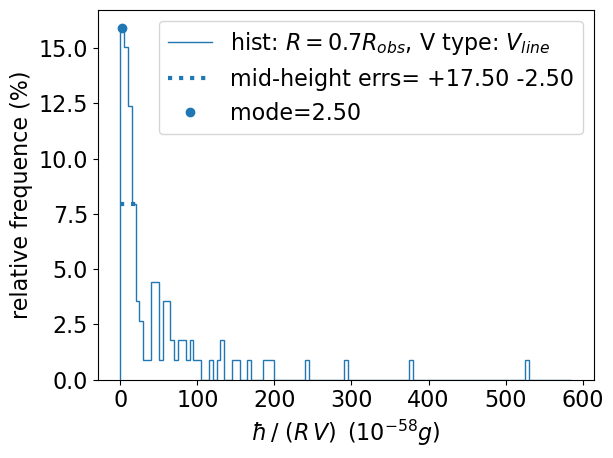

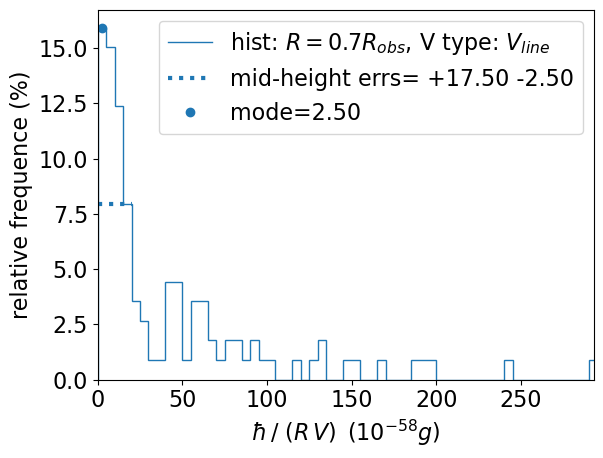

In [165]:
#parameters - select reference R,V
percR = 0.7
typeV = "VL" 
#graphical parameters
col = "tab:blue"
#output data parameters
dirOut = "Figures"
nameOut_hist = "hist_R"+str(int(percR*100))+"_"+typeV+".png"
nameOut_histZoomed = "histZoomed_R"+str(int(percR*100))+"_"+typeV+".png"

#----------------------------------------------------------------------
#function to load elements
def loadElems(dirIn="Results",fileIn="RVelements.dat"):
    elements_list = []
    with open(dirIn+"/"+fileIn, "r") as file1:
        for line in file1.readlines()[1:]:
            row = line.split(" ")
            row[2:] = [float(r) for r in row[2:]]
            row[1] = int(row[1])
            row[4] = int(row[4])
            row[5] = int(row[5])
            elements_list.append(row)
    return elements_list

#----------------------------------------------------------------------
#load elements (R,V)
elements_list = loadElems()
#select R
if [el.index(percR) for el in elements_list] == []:
    print("Percentage not valid")
    R_list = []
else:
    R_list = np.array([el[el.index(percR)+1] for el in elements_list])
    labelR = f"$R = {percR:.1f}R_{{obs}}$"
#select V
if typeV=="Vflat":
    V_list = np.array([el[6] for el in elements_list])
    labelV = f"V type: $V_{{flat}}$"
elif typeV=="VL":
    V_list = np.array([el[el.index(percR)+2] for el in elements_list])
    labelV = f"V type: $V_{{line}}$"
elif typeV=="VE":
    V_list = np.array([el[el.index(percR)+1] for el in elements_list])
    labelV = f"V type: $V_{{exact}}$"
else:
    print("Velocity type not valid")
#compute h/RV
hbar = 1.0546 #10^-27 g cm^2 /s
hRV_list = hbar/(R_list*V_list) *100000/ee.PC #10^-58 g

# HISTOGRAMS 
#define histogram
m_bins = np.arange(0,np.max(hRV_list)+1,5)
counts, _ = np.histogram(hRV_list,bins=m_bins,weights=np.ones(len(hRV_list))/len(hRV_list)*100)
#histogram elements (mode, mid-height error)
maxCount = np.max(counts)
point_maxCount = ( m_bins[np.argmax(counts)]+ m_bins[np.argmax(counts)+1] )/2
idx_midCount = np.where(counts>=maxCount/2)[0]
edges_midCount = np.array([m_bins[idx_midCount[0]],m_bins[idx_midCount[-1]+1]])
errLeft  =   point_maxCount - edges_midCount[0]
errRight = - point_maxCount + edges_midCount[1]
#plot histogram
plt.figure()
plt.stairs(counts, m_bins,color=col,label="hist: "+labelR+", "+labelV)
plt.plot(edges_midCount,np.array([maxCount/2,maxCount/2]),color=col,linestyle=":",label=f"mid-height errs= +{errRight:.2f} -{errLeft:.2f}")
plt.plot(point_maxCount,maxCount,'o',color=col,label=f"mode={point_maxCount:.2f}")
plt.xlabel(f"$\hbar \,/\,\, (R\, V) \,\,\,( 10^{{-58}} g)$")
plt.ylabel(f"relative frequence (%)")
plt.legend()
#save plot
figpath = os.path.join(dirOut,nameOut_hist)
plt.savefig(figpath,dpi=300)
#magnified histogram
plt.figure()
plt.stairs(counts, m_bins,color=col,label="hist: "+labelR+", "+labelV)
plt.plot(edges_midCount,np.array([maxCount/2,maxCount/2]),color=col,linestyle=":",label=f"mid-height errs= +{errRight:.2f} -{errLeft:.2f}")
plt.plot(point_maxCount,maxCount,'o',color=col,label=f"mode={point_maxCount:.2f}")
plt.xlabel(f"$\hbar \,/\,\, (R\, V) \,\,\,( 10^{{-58}} g)$")
plt.ylabel(f"relative frequence (%)")
plt.legend()
plt.xlim((0,sorted(hRV_list)[-4]))
#save plot
figpath = os.path.join(dirOut,nameOut_histZoomed)
plt.savefig(figpath,dpi=300)



# Side tests
---
*Test:* Alternatively to the histograms, $\hbar/(RV)$ data may be plotted in a standard plot. <br>
Based on the choice of the x-axis, one can check for residual dependencies of $\hbar/(RV)$ on the variables.

*Result:* With these definition of $(R,V)$, the $\hbar/(RV)$ still depends exponentially on $R$ and on $V$.

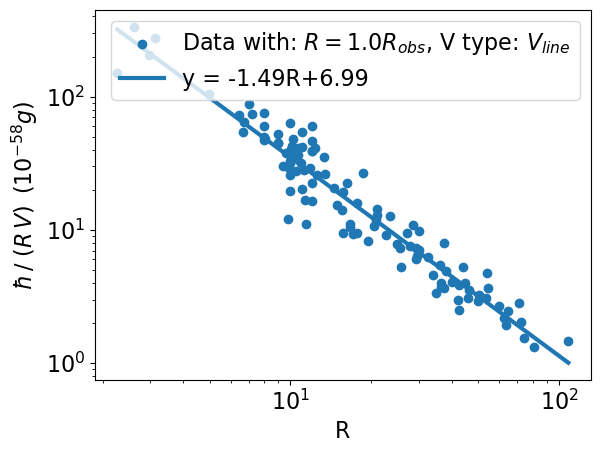

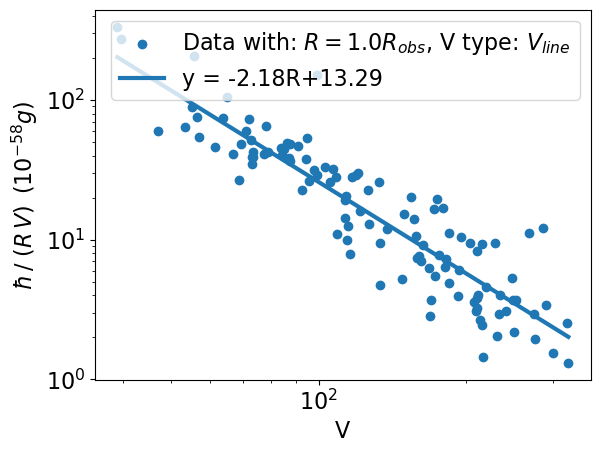

In [4]:
#parameters - select reference R,V
percR = 1.0
typeV = "VL" #Vflat, VL, VE
#graphical parameters
col = "tab:blue"
#output data parameters
dirOut = "Figures"

#----------------------------------------------------------------------
#function to load elements
def loadElems(dirIn="Results",fileIn="RVelements.dat"):
    elements_list = []
    with open(dirIn+"/"+fileIn, "r") as file1:
        for line in file1.readlines()[1:]:
            row = line.split(" ")
            row[2:] = [float(r) for r in row[2:]]
            row[1] = int(row[1])
            row[4] = int(row[4])
            row[5] = int(row[5])
            elements_list.append(row)
    return elements_list

#----------------------------------------------------------------------
#load elements (R,V)
elements_list = loadElems()
#select R
if [el.index(percR) for el in elements_list] == []:
    print("Percentage not valid")
    R_list = []
else:
    R_list = np.array([el[el.index(percR)+1] for el in elements_list])
    labelR = f"$R = {percR:.1f}R_{{obs}}$"
#select V
if typeV=="Vflat":
    V_list = np.array([el[6] for el in elements_list])
    labelV = f"V type: $V_{{flat}}$"
elif typeV=="VL":
    V_list = np.array([el[el.index(percR)+2] for el in elements_list])
    labelV = f"V type: $V_{{line}}$"
elif typeV=="VE":
    V_list = np.array([el[el.index(percR)+1] for el in elements_list])
    labelV = f"V type: $V_{{exact}}$"
else:
    print("Velocity type not valid")
#compute h/RV
hbar = 1.0546 #10^-27 g cm^2 /s
hRV_list = hbar/(R_list*V_list) *100000/ee.PC #10^-58 g

#fit (R, h/RV)
m,q = np.polyfit(np.log(R_list),np.log(hRV_list),1)
#plot against R
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.scatter(R_list, hRV_list,color=col,label="Data with: "+labelR+", "+labelV)
plt.plot(np.array(sorted(R_list)), np.exp(q)*np.array(sorted(R_list))**m,'-',color=col,label=f"y = {m:.2f}R{q:+.2f}")
plt.xlabel("R")
plt.ylabel(f"$\hbar \,/\,\, (R\, V) \,\,\,( 10^{{-58}} g)$")
plt.legend()

#fit (V, h/RV)
m,q = np.polyfit(np.log(V_list),np.log(hRV_list),1)
#plot against R
plt.figure()
plt.xscale("log")
plt.yscale("log")
plt.scatter(V_list, hRV_list,color=col,label="Data with: "+labelR+", "+labelV)
plt.plot(np.array(sorted(V_list)), np.exp(q)*np.array(sorted(V_list))**m,'-',color=col,label=f"y = {m:.2f}R{q:+.2f}")
plt.xlabel("V")
plt.ylabel(f"$\hbar \,/\,\, (R\, V) \,\,\,( 10^{{-58}} g)$")
plt.legend()
        


## Comparing radii
---

*Test:* this cell compares the observed radii (defined as percentages of the largest measured radii) to tabulated values in SPARC: the hydrogen characteristic radius, the disk characteristic radius and the luminosity.

*Result:* the relation between $R_{obs}$ and the hydrogen characteristic radius is exponential (linear in log-log scale); a similar but more rough result holds for the comparison with the disk characteristic radius and the luminosity.

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_11048\279193497.py:58: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  values = np.fromstring(line[11:-14], dtype=float, sep=' ')


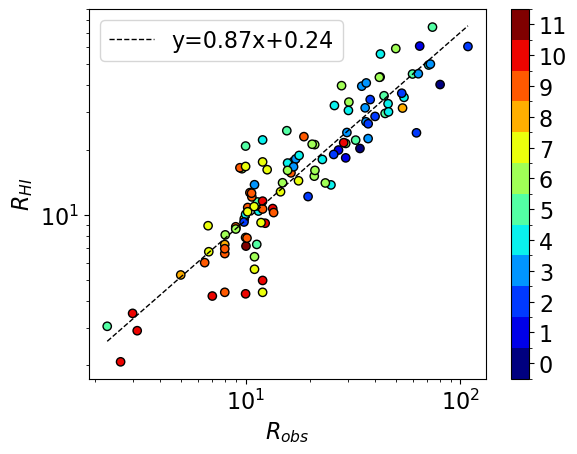

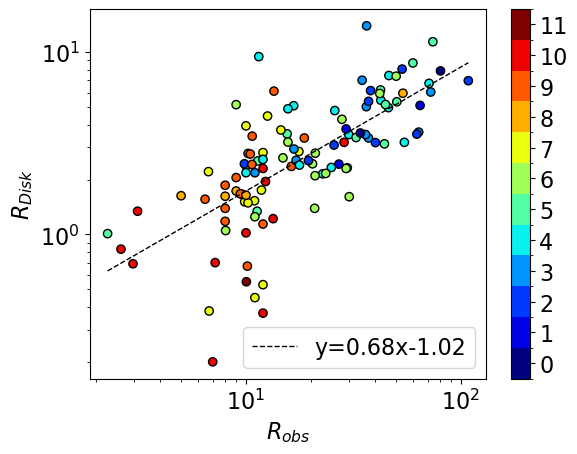

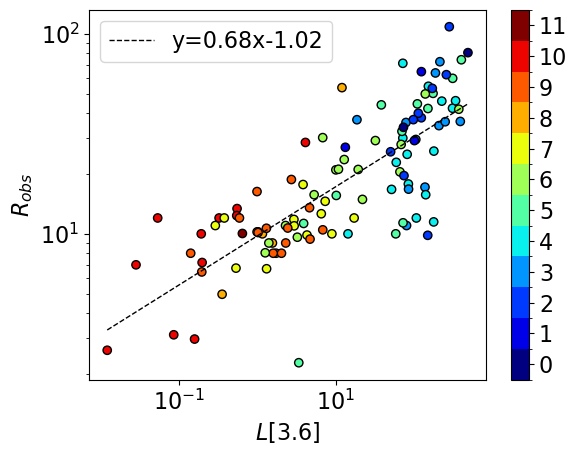

In [10]:
#parameters - select reference R
percR = 1.0
# figure settings
cmap = plt.cm.jet
norm = colors.BoundaryNorm(np.arange(-0.5, 12, 1), cmap.N)

#----------------------------------------------------------------------
#function to load elements
def loadElems(dirIn="Results",fileIn="RVelements.dat"):
    elements_list = []
    with open(dirIn+"/"+fileIn, "r") as file1:
        for line in file1.readlines()[1:]:
            row = line.split(" ")
            row[2:] = [float(r) for r in row[2:]]
            row[1] = int(row[1])
            row[4] = int(row[4])
            row[5] = int(row[5])
            elements_list.append(row)
    return elements_list

#----------------------------------------------------------------------
#load elements (R,V)
elements_list = loadElems()
#select R
if [el.index(percR) for el in elements_list] == []:
    print("Percentage not valid")
    rObs_list = []
else:
    rObs_list = np.array([el[el.index(percR)+1] for el in elements_list])
    labelR = f"$R = {percR:.1f}R_{{obs}}$"

#load table
table = readTable1()
#load indexes
idx_data = [el[1] for el in elements_list]

# lists of data
rHI_list  = np.array([table[k]["RHI"] for k in idx_data])
rDisk_list  = np.array([table[k]["Rdisk"] for k in idx_data])
rObs_list = R_list
L36_list  = np.array([table[k]["L[3.6]"] for k in idx_data])
hType_list = np.array([table[k]["T"] for k in idx_data])

# fits
mHI, qHI = np.polyfit(np.log(rObs_list[ np.where(rHI_list != 0) ]),np.log(rHI_list[ np.where(rHI_list != 0) ]),1)      # log-log linear fit, Robs = b*L36^a 
mD, qD = np.polyfit(np.log(rObs_list),np.log(rDisk_list),1)
mRoL, qRoL = np.polyfit(np.log(L36_list),np.log(rObs_list),1)

# domains for plotting fits
rObsEdges = np.array([np.min(rObs_list),np.max(rObs_list)])
L36Edges  =  np.array([np.min(L36_list),np.max(L36_list)])

#--- RHI versus Robs
plt.figure()
plt.xscale("linear")
plt.yscale("linear")
plt.xscale("log")
plt.yscale("log")
# plt.plot([0,100],[0,100],':',color="black",linewidth=1,label="y=x")
plt.plot(rObsEdges,np.exp(qHI)*rObsEdges**mHI,'--',color="black",linewidth=1,label=f"y={mHI:.2f}x{qHI:+.2f}")
plt.scatter(rObs_list,rHI_list,c=hType_list, cmap=cmap, norm=norm, ec='k',label="")
plt.colorbar(ticks=np.linspace(0, 11, 12))
plt.xlabel(f"$R_{{obs}}$")
plt.ylabel(f"$R_{{HI}}$")
plt.legend()
# plt.axis('scaled')

#--- RDisk versus Robs
plt.figure()
plt.xscale("linear")
plt.yscale("linear")
plt.xscale("log")
plt.yscale("log")
# plt.plot([0,14],[0,14],':',color="black",linewidth=1,label="y=x")
plt.plot(rObsEdges,np.exp(qD)*rObsEdges**mD,'--',color="black",linewidth=1,label=f"y={mD:.2f}x{qD:+.2f}")
plt.scatter(rObs_list,rDisk_list,c=hType_list, cmap=cmap, norm=norm, ec='k',label="")
plt.colorbar(ticks=np.linspace(0, 11, 12))
plt.xlabel(f"$R_{{obs}}$")
plt.ylabel(f"$R_{{Disk}}$")
plt.legend()
# plt.axis('scaled')

#--- RObs versus luminosity
plt.figure()
plt.xscale("log")
plt.yscale("log")
# plt.plot([0,14],[0,14],':',color="black",linewidth=1,label="y=x")
plt.plot(L36Edges,np.exp(qRoL)*L36Edges**mRoL,'--',color="black",linewidth=1,label=f"y={mD:.2f}x{qD:+.2f}")
plt.scatter(L36_list,rObs_list,c=hType_list, cmap=cmap, norm=norm, ec='k',label="")
plt.colorbar(ticks=np.linspace(0, 11, 12))
plt.xlabel(f"$L[3.6]$")
plt.ylabel(f"$R_{{obs}}$")
plt.legend()
# plt.axis('scaled')

## Visulaizing slopes
---
Slopes from the mid-range linear fit are visualized across the galaxies, with optional sortings.

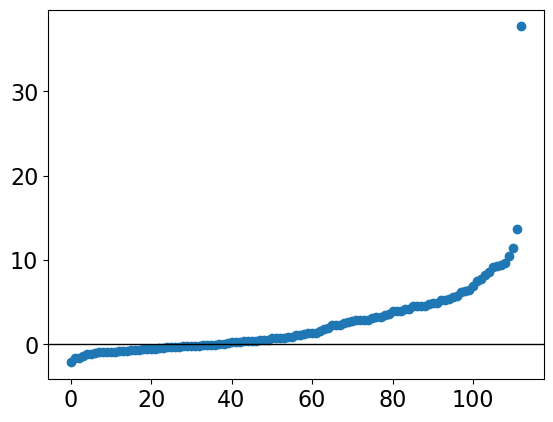

In [ ]:
#parameters
sortingKey = "slopes" #available: "slopes", "radius","velocity"
#----------------------------------------------------------------------
#function to load elements
def loadElems(dirIn="Results",fileIn="RVelements.dat"):
    elements_list = []
    with open(dirIn+"/"+fileIn, "r") as file1:
        for line in file1.readlines()[1:]:
            row = line.split(" ")
            row[2:] = [float(r) for r in row[2:]]
            row[1] = int(row[1])
            row[4] = int(row[4])
            row[5] = int(row[5])
            elements_list.append(row)
    return elements_list

#----------------------------------------------------------------------
#load elements (R,V)
elements_list = loadElems()
#select slopes
slopes_list = [el[3] for el in elements_list]
#sorting
sorted_idx_data = sorted(idx_data, key=lambda k: table[k]["L[3.6]"])
idxSort = np.array([list(idx_data).index(k) for k in sorted_idx_data])
#visualize slopes
plt.plot(sorted(slopes_list),'o')
plt.axhline(y=0, color='black',linewidth=1)

#slopes against R